> Simulation

https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/dataset.html#module-torch_geometric_temporal.dataset.chickenpox

### import

In [39]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

### 공식 홈페이지 예제

#### data

In [40]:
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = WikiMathsDatasetLoader()

dataset = loader.get_dataset(lags=14)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

#### RecurrentGCN

In [41]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

#### Learn

In [42]:
from tqdm import tqdm

model = RecurrentGCN(node_features=14, filters=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((y_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [09:56<00:00, 11.92s/it]


In [43]:
for time, snapshot in enumerate(train_dataset):
    _x = snapshot.x 
    _edge_index = snapshot.edge_index 
    _edge_attr = snapshot.edge_attr
    _y = snapshot.y
    break

In [44]:
_x.shape

torch.Size([1068, 14])

- 1068개의 nodes
- 한 개의 node에 mapping된 차원의 수

In [45]:
_edge_index.shape

torch.Size([2, 27079])

In [46]:
_edge_attr.shape

torch.Size([27079])

In [47]:
_y.shape

torch.Size([1068])

In [48]:
_x.shape

torch.Size([1068, 14])

### 우리 예제

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [26]:
T = 100
N = 4 # number of Nodes
E = np.array([[0,1],[1,2],[2,3],[3,0]]).T
V = np.array([1,2,3,4])
AMP = np.array([3,2,1,2.2])
t = np.arange(0,T)
node_features = 1

In [27]:
f = np.stack([a*np.sin(2*t**2/1000)+np.random.normal(loc=0,scale=0.2,size=T) for a in AMP],axis=1).reshape(T,N,node_features)
f = torch.tensor(f).float()

In [28]:
f.shape

torch.Size([100, 4, 1])

In [29]:
X = f[:99,:,:]
y = f[1:,:,:]

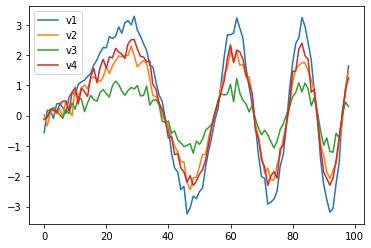

In [30]:
plt.plot(y[:,0,0],label="v1")
plt.plot(y[:,1,0],label="v2")
plt.plot(y[:,2,0],label="v3")
plt.plot(y[:,3,0],label="v4")
plt.legend()

In [31]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1]),dtype=torch.float32)

In [32]:
_ee = enumerate(zip(X,y))

In [33]:
from tqdm import tqdm

model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:16<00:00,  2.98it/s]


In [34]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

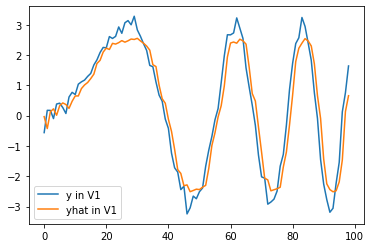

In [35]:
plt.plot(y[:,0,0],label="y in V1")
plt.plot(yhat[:,0,0],label="yhat in V1")
plt.legend()

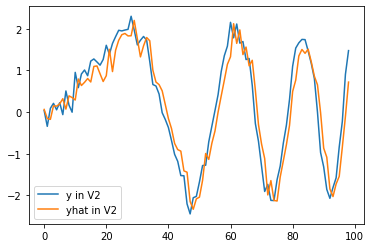

In [36]:
plt.plot(y[:,1,0],label="y in V2")
plt.plot(yhat[:,1,0],label="yhat in V2")
plt.legend()

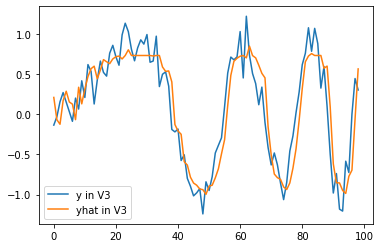

In [37]:
plt.plot(y[:,2,0],label="y in V3")
plt.plot(yhat[:,2,0],label="yhat in V3")
plt.legend()

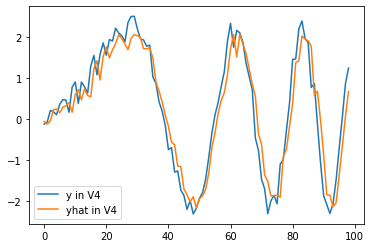

In [38]:
plt.plot(y[:,3,0],label="y in V4")
plt.plot(yhat[:,3,0],label="yhat in V4")
plt.legend()